# Data loading

Training data is distributed in 3 different folders (set a, b and c).
Each file has its raw image (.mhd), lung mask (\_lm.mhd), and fissure mask (\_fm.mhd).

In [1]:
import os, random
import ntpath
import SimpleITK
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np


In [2]:
workdir = '/projects/0/ismi2018/FINALPROJECTS/CHESTCT_FISSURE_INTEGRITY/'
train_A_images = os.path.join(workdir, 'set-a')
train_B_images = os.path.join(workdir, 'set-b')
train_C_images = os.path.join(workdir, 'set-c')

a22_fm.mhd
(241, 345, 577)


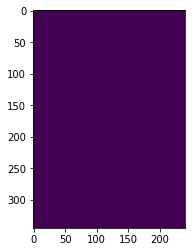

In [3]:
#Print one file:
case = os.path.join(train_A_images, random.choice(os.listdir(train_A_images)))
case_filename = os.path.splitext(ntpath.basename(case))[0] + '.mhd'
img = SimpleITK.ReadImage(train_A_images+ '/' + case_filename)

piece = SimpleITK.GetArrayViewFromImage(img)[50,:,:] #<-- Specify a number for the z-index slice
print(case_filename)
print(img.GetSize())
plt.imshow(piece)


In [4]:
''' Helper function '''
def load_unique_image_names(folder):
    
    uniqueimglist = []
    for file in os.listdir(folder):
        file = file.replace(".mhd", "")
        file = file.replace("_lm", "")
        file = file.replace("_fm", "")
        file = file.replace(".zraw", "")
        if ".csv" not in file:
            uniqueimglist.append(file)
    uniqueimglist = list(set(uniqueimglist))
    return uniqueimglist


''' Load training data from a folder'''
def load_training_set(folder):
    fileList = load_unique_image_names(folder)
    
    trainSet = []
    for file in fileList:
        filePath = folder + '/' + file
        image = lungMask = fissureMask = None
        try:
            image = SimpleITK.ReadImage(filePath + '.mhd')
            lungMask = SimpleITK.ReadImage(filePath + '_lm.mhd')
            fissureMask = SimpleITK.ReadImage(filePath + '_fm.mhd')
            label = file[0]
            trainSet.append({'name': file, 
                         'image': image, 
                         'lungmask': lungMask,
                         'fissuremask': fissureMask,
                         'label': label})
        except :
            print("Error reading file: " + file)
            
    return trainSet

def get_exact_csv_set(folder, label):
    return pd.read_csv(folder + '/LUT-' + label + '.csv')
    


In [5]:
print("Loading train set...")
training = load_training_set(train_A_images)
training.extend(load_training_set(train_B_images))
training.extend(load_training_set(train_C_images))
training = pd.DataFrame(training)
print("Done loading!")

Loading train set...
Done loading!


Accessing the LUT csv files to attach the exact percentages to the training set:

In [6]:

exact = get_exact_csv_set(train_A_images, 'a') # 60
exact = exact.append(get_exact_csv_set(train_B_images, 'b'), ignore_index=True) # 38
exact = exact.append(get_exact_csv_set(train_C_images, 'c'), ignore_index=True) # 102
exact = exact.rename(columns={'Fissure_completeness': 'completeness'})

print("exact size: ", exact.size)
print("training size: ", training.size)

'''
emptyList = []
trainList = []
for el in training['name']:
    trainList.append(el)
    if el not in exact['New ID']:
        emptyList.append(el)
print(sorted(emptyList))
print(sorted(trainList))
print("Do the csv files represent the whole training set?")
print(sorted(trainList)== sorted(emptyList) )

exact['New ID'].iloc[31]
'''


# Join the csv set with the training set
training = pd.merge(training, exact, left_on='name', right_on='New ID')
training = training.drop('New ID', 1)


exact size:  200
training size:  500


In [7]:
training.head(5)

,fissuremask,image,label,lungmask,name,completeness
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[116, 119, 93, 73, 47, 62, 44, 30, 46, 78, 42,...",a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",a09,57.2298
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-131, -147, -146, -78, -41, -99, -81, -92, -8...",a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",a25,77.9893
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-105, -124, -132, -140, -122, -49, -51, -122,...",a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",a04,46.2267
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-133, -146, -152, -117, -92, -98, -80, -93, -...",a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",a05,46.3949
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[9, 37, 93, 6, 2, -62, -96, -14, 53, -59, -2, ...",a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",a18,72.2658


## Accessing the data

We attached the labels LUT-a.csv (etc...) to the training data in order to make it into a regression problem. Now, we would like to save this dataframe to file. Unfortunately, this can't be done, as the image elements aren't pickle-able (_Python can't pickle swigpy objects_).



- (Data) Raw images can be accessed by utilizing `training['image'].values`. This will return an array with the SimpleITK images.
- (Label) Classification labels _(a,b,c)_ can be obtained by `training['label'].values`.
- (Label) Regression labels _Fissure completeness percentage (%)_ can be obtained by `training['completeness'].values`.

Save the training set to file

*Actually can't be done, as it can't pickle swigpy objects..*

In [8]:
#store = pd.HDFStore('database.h5')
#store['trainingset'] = training

In [9]:
#training.to_pickle('./train-data.pkl')

Completeness:  79.3114


array([0, 2, 4], dtype=uint8)

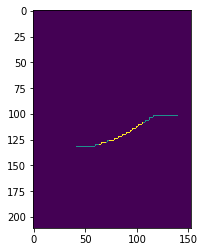

In [10]:
img = training['fissuremask'].iloc[15]
piece = SimpleITK.GetArrayViewFromImage(img)[240,:,:]
plt.imshow(piece)
print("Completeness: ", training['completeness'].iloc[15])
np.unique(piece)

# Split data between validation and training set 

In [11]:
percentage_validation = 0.2

In [12]:
count_a = 0
count_b = 0
count_c = 0

for i, label in enumerate(training['label'].values):
    if label == 'a':
        count_a = count_a +1
    if label == 'b':
        count_b = count_b +1
    else :
        count_c = count_c +1
            


In [13]:
validation_data_a = training.loc[training['label'].values == 'a', :].sample(n=int(count_a*percentage_validation))
validation_data_b = training.loc[training['label'].values == 'b', :].sample(n=int(count_b*percentage_validation))
validation_data_c = training.loc[training['label'].values == 'c', :].sample(n=int(count_c*percentage_validation))

validation_data = pd.concat([validation_data_a, validation_data_b, validation_data_c])

In [14]:
training_data = training.loc[~training['name'].isin(validation_data['name'])]

In [15]:
test = [1,2,3,4,5]

In [27]:
def get_batch(list_idx, df):
    batch = pd.DataFrame()
    for i, row in df.iterrows():
        if i in list_idx: 
            print(row)
            batch.append(row, ignore_index=True)
        print(i)
    return batch 

print(len(get_batch(test, training_data)))

1
2
3
5
6
8
9
10
12
13
14
15
17
18
19
20
21
22
23
24
25
26
27
28
30
31
32
34
35
38
39
40
41
42
43
44
45
46
47
48
49
50
53
54
55
56
57
61
62
63
64
67
68
69
70
71
72
74
75
77
79
80
82
85
87
88
89
90
91
92
93
96
97
98
99
0
